<a href="https://colab.research.google.com/github/MithilaCoomaraswamy/DSGP/blob/Period-Tracker/Menses_Date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [307]:
pip install pycaret

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from pycaret.regression import setup, create_model, compare_models, evaluate_model, save_model, predict_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [309]:
df = pd.read_csv('PeriodData.csv')
np.random.seed(42)

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ClientID                    1665 non-null   object
 1   CycleNumber                 1665 non-null   int64 
 2   Group                       1665 non-null   int64 
 3   CycleWithPeakorNot          1665 non-null   int64 
 4   ReproductiveCategory        1665 non-null   int64 
 5   LengthofCycle               1665 non-null   int64 
 6   MeanCycleLength             1665 non-null   object
 7   EstimatedDayofOvulation     1665 non-null   object
 8   LengthofLutealPhase         1665 non-null   object
 9   FirstDayofHigh              1665 non-null   object
 10  TotalNumberofHighDays       1665 non-null   object
 11  TotalHighPostPeak           1665 non-null   object
 12  TotalNumberofPeakDays       1665 non-null   object
 13  TotalDaysofFertility        1665 non-null   obje

In [311]:
df = df[['ClientID', 'CycleNumber', 'LengthofCycle', 'MeanCycleLength', 'LengthofMenses', 'MeanMensesLength']]

In [312]:
df['MeanCycleLength'] = df.groupby('ClientID')['MeanCycleLength'].transform('first')
df['MeanMensesLength'] = df.groupby('ClientID')['MeanMensesLength'].transform('first')

In [313]:
def fill_missing_menses_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanMensesLength' is missing (NaN), calculate the mean of 'LengthofMenses'
        if group['MeanMensesLength'].isnull().any():
            mean_menses_length = group['LengthofMenses'].mean()

            # Fill missing MeanMensesLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanMensesLength'] = df.loc[df['ClientID'] == client_id, 'MeanMensesLength'].fillna(mean_menses_length)

    return df

In [314]:
df = fill_missing_menses_length(df)

In [315]:
def fill_missing_menses_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanMensesLength' is missing (NaN), calculate the mean of 'LengthofMenses'
        if group['MeanMensesLength'].isnull().any():
            mean_menses_length = group['LengthofMenses'].mean()

            # Fill missing MeanMensesLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanMensesLength'] = df.loc[df['ClientID'] == client_id, 'MeanMensesLength'].fillna(mean_menses_length)

    return df

In [316]:
df = fill_missing_menses_length(df)

In [317]:
def fill_missing_cycle_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanCycleLength' is missing (NaN), calculate the mean of 'LengthofCycle'
        if group['MeanCycleLength'].isnull().any():
            mean_cycle_length = group['LengthofCycle'].mean()

            # Fill missing MeanCycleLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanCycleLength'] = df.loc[df['ClientID'] == client_id, 'MeanCycleLength'].fillna(mean_cycle_length)

    return df

In [318]:
df = fill_missing_cycle_length(df)

In [319]:
df = df[df['ClientID'] != 'nfp8085']

In [320]:
df = df[df['ClientID'] != 'nfp8226' ]

In [321]:
df.loc[:, 'LengthofMenses'] = df.groupby('ClientID')['LengthofMenses'].transform(lambda x: pd.to_numeric(x, errors='coerce').fillna(pd.to_numeric(x, errors='coerce').mean()))

In [322]:
rows_with_missing_values = df[df.isnull().any(axis=1)]
print(rows_with_missing_values)

Empty DataFrame
Columns: [ClientID, CycleNumber, LengthofCycle, MeanCycleLength, LengthofMenses, MeanMensesLength]
Index: []


In [323]:
# Check for duplicate rows.
print(f"There are {df.duplicated().sum()} duplicate rows in the data set.")

# Remove duplicate rows.
df=df.drop_duplicates()
print("The duplicate rows were removed.")

There are 15 duplicate rows in the data set.
The duplicate rows were removed.


In [324]:
df = df.drop(columns=['ClientID'])

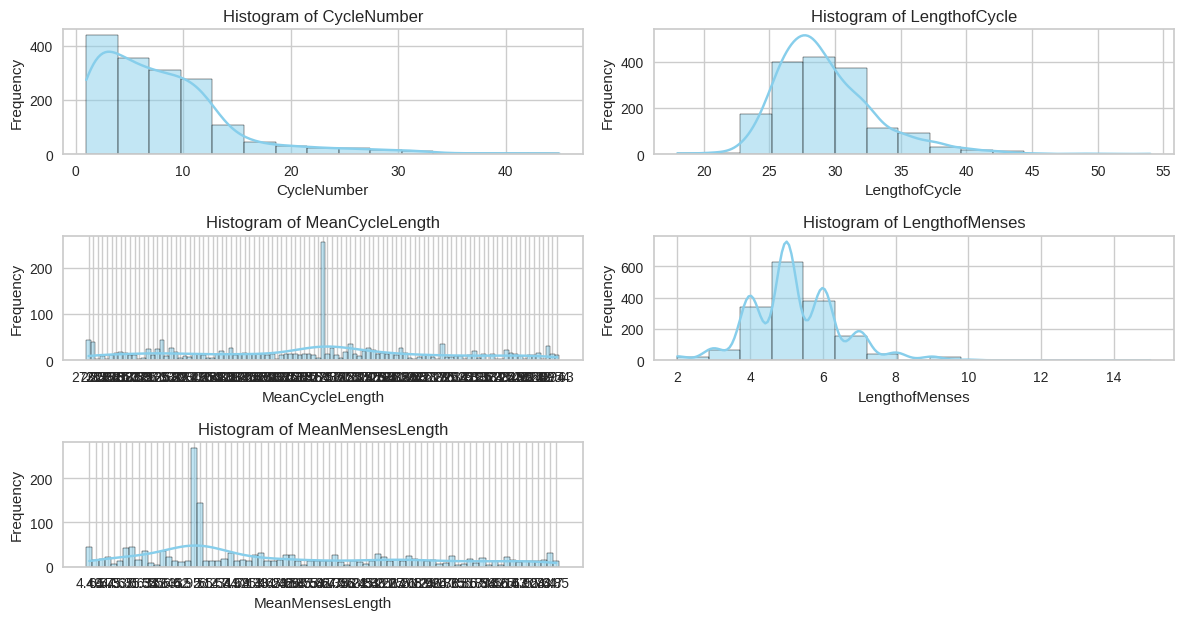

In [325]:
# Plot histograms
columns_to_plot = ['CycleNumber', 'LengthofCycle', 'MeanCycleLength', 'LengthofMenses','MeanMensesLength']

plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[column], bins=15, kde=True, color='skyblue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

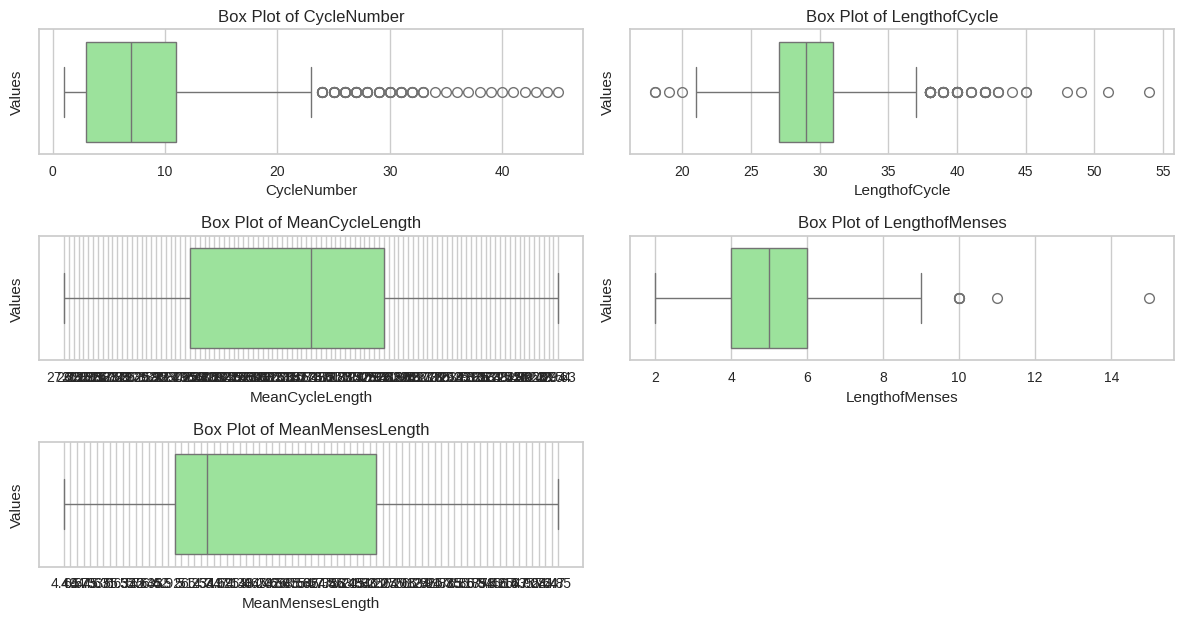

In [326]:
# Draw box plots to check for outliers
plt.figure(figsize=(12, 8))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)  # 2 rows, 2 columns
    sns.boxplot(x=df[column], color='lightgreen')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')

plt.tight_layout()

plt.show()

In [327]:
# Identify outliers using IQR
def handle_outliers(df, column):
    # Ensure the column is numeric before calculating quantiles
    df[column] = pd.to_numeric(df[column], errors='coerce')

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

for col in ['LengthofCycle', 'LengthofMenses', 'MeanMensesLength', 'MeanCycleLength']:
    df = handle_outliers(df, col)

In [328]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select the columns to normalize (exclude the target variable)
cols_to_normalize = ['CycleNumber', 'MeanCycleLength', 'LengthofMenses', 'MeanMensesLength']

# Fit the scaler on the training data and transform
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

In [342]:
# Now proceed with PyCaret setup
from pycaret.regression import *

# Ensure 'EstimatedDayofOvulation' is numeric and not categorical.
# PyCaret might be mistaking it as categorical.
df['LengthofCycle'] = pd.to_numeric(df['LengthofCycle'], errors='coerce')

# Exclude 'EstimatedDayofOvulation' from numeric_features since it is the target
reg_setup = setup(data=df, target='LengthofCycle')

# Compare regression models
best_model = compare_models()

# Create the best regression model
lr_model = create_model('lr')
ridge_model = create_model('ridge')
lar_model = create_model('lar')
br_model = create_model('br')
huber_model = create_model('huber')
rf_model = create_model('rf')
lgbm_model = create_model('lightgbm')



stacked_model = stack_models([huber_model, lr_model, lgbm_model, rf_model], meta_model=None)

# Evaluate the model
evaluate_model(stacked_model)

# Predict using the model on new data
predictions = predict_model(stacked_model, data=df)

# Save the model for future use
save_model(stacked_model, 'menses_model')

tuned_stacked_model = tune_model(stacked_model)
evaluate_model(tuned_stacked_model)

,Description,Value
0,Session id,8811
1,Target,LengthofCycle
2,Target type,Regression
3,Original data shape,"(1647, 5)"
4,Transformed data shape,"(1647, 5)"
5,Transformed train set shape,"(1152, 5)"
6,Transformed test set shape,"(495, 5)"
7,Numeric features,4
8,Rows with missing values,17.0%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,1.8770,6.2996,2.4988,0.4691,0.0809,0.0638,0.6370
lar,Least Angle Regression,1.8770,6.2996,2.4988,0.4691,0.0809,0.0638,0.0210
br,Bayesian Ridge,1.8769,6.2995,2.4988,0.4691,0.0809,0.0638,0.0230
ridge,Ridge Regression,1.8768,6.3022,2.4993,0.4690,0.0809,0.0638,0.0380
huber,Huber Regressor,1.8639,6.3294,2.5042,0.4670,0.0809,0.0630,0.0330
omp,Orthogonal Matching Pursuit,1.8731,6.4122,2.5217,0.4593,0.0816,0.0637,0.0210
gbr,Gradient Boosting Regressor,1.9754,6.7794,2.5920,0.4279,0.0841,0.0672,0.1040
ada,AdaBoost Regressor,2.0047,6.8605,2.6126,0.4187,0.0850,0.0687,0.0540
knn,K Neighbors Regressor,2.0991,7.6832,2.7590,0.3527,0.0895,0.0714,0.0280
lightgbm,Light Gradient Boosting Machine,2.1104,7.7376,2.7698,0.3465,0.0900,0.0719,0.1130


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1991,8.3908,2.8967,0.4666,0.0915,0.0729
1,1.9626,6.1019,2.4702,0.4178,0.0791,0.0664
2,2.1546,7.8303,2.7983,0.4101,0.0906,0.0733
3,1.8858,6.8439,2.6161,0.4109,0.0863,0.0649
4,1.7188,5.4939,2.3439,0.4614,0.0782,0.0608
5,1.9645,6.8107,2.6097,0.4215,0.0833,0.0656
6,1.8493,6.0353,2.4567,0.4107,0.0787,0.0623
7,1.6438,5.1549,2.2704,0.5355,0.0760,0.0577
8,1.5787,4.2070,2.0511,0.6305,0.0667,0.0537


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2075,8.4111,2.9002,0.4653,0.0916,0.0731
1,1.9619,6.1026,2.4704,0.4178,0.0791,0.0664
2,2.1577,7.8480,2.8014,0.4087,0.0908,0.0734
3,1.8827,6.8561,2.6184,0.4098,0.0864,0.0648
4,1.7228,5.4936,2.3438,0.4614,0.0782,0.0610
5,1.9593,6.8202,2.6115,0.4207,0.0834,0.0655
6,1.8419,5.9764,2.4447,0.4165,0.0783,0.0620
7,1.6346,5.1276,2.2644,0.5380,0.0758,0.0574
8,1.5845,4.2325,2.0573,0.6283,0.0669,0.0539


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1991,8.3908,2.8967,0.4666,0.0915,0.0729
1,1.9626,6.1019,2.4702,0.4178,0.0791,0.0664
2,2.1546,7.8303,2.7983,0.4101,0.0906,0.0733
3,1.8858,6.8439,2.6161,0.4109,0.0863,0.0649
4,1.7188,5.4939,2.3439,0.4614,0.0782,0.0608
5,1.9645,6.8107,2.6097,0.4215,0.0833,0.0656
6,1.8493,6.0353,2.4567,0.4107,0.0787,0.0623
7,1.6438,5.1549,2.2704,0.5355,0.0760,0.0577
8,1.5787,4.2070,2.0511,0.6305,0.0667,0.0537


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.2005,8.3936,2.8972,0.4664,0.0915,0.0729
1,1.9625,6.1015,2.4701,0.4179,0.0791,0.0664
2,2.1549,7.8330,2.7988,0.4099,0.0906,0.0733
3,1.8851,6.8458,2.6164,0.4107,0.0863,0.0649
4,1.7194,5.4936,2.3438,0.4614,0.0782,0.0608
5,1.9636,6.8120,2.6100,0.4214,0.0833,0.0656
6,1.8479,6.0239,2.4544,0.4118,0.0786,0.0622
7,1.6420,5.1490,2.2691,0.5361,0.0760,0.0576
8,1.5798,4.2111,2.0521,0.6302,0.0668,0.0537


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1888,8.4583,2.9083,0.4623,0.0916,0.0721
1,1.9562,6.1576,2.4814,0.4125,0.0793,0.0659
2,2.1535,7.9224,2.8147,0.4031,0.0910,0.0729
3,1.8797,6.9284,2.6322,0.4036,0.0866,0.0644
4,1.6968,5.4711,2.3390,0.4636,0.0777,0.0596
5,1.9524,6.8929,2.6254,0.4145,0.0837,0.0649
6,1.8310,5.9544,2.4402,0.4186,0.0780,0.0614
7,1.6108,5.0179,2.2401,0.5479,0.0749,0.0563
8,1.5705,4.2605,2.0641,0.6259,0.0670,0.0532


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4610,10.4465,3.2321,0.3359,0.1033,0.0819
1,2.1198,7.0040,2.6465,0.3318,0.0856,0.0725
2,2.4669,10.2200,3.1969,0.2300,0.1039,0.0843
3,2.2215,9.4274,3.0704,0.1885,0.1019,0.0766
4,2.1064,7.6556,2.7669,0.2495,0.0922,0.0751
5,2.1582,8.4861,2.9131,0.2792,0.0932,0.0718
6,2.0823,7.4410,2.7278,0.2735,0.0875,0.0700
7,1.8142,6.5417,2.5577,0.4106,0.0851,0.0634
8,1.9108,6.1315,2.4762,0.4615,0.0802,0.0651


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.4646,10.3034,3.2099,0.3450,0.1019,0.0818
1,2.0844,7.0155,2.6487,0.3307,0.0849,0.0706
2,2.3560,9.3996,3.0659,0.2918,0.0997,0.0807
3,2.2095,8.7206,2.9531,0.2493,0.0981,0.0764
4,2.0310,7.0995,2.6645,0.3040,0.0888,0.0723
5,2.2037,8.3647,2.8922,0.2895,0.0927,0.0735
6,2.1704,7.8985,2.8104,0.2288,0.0902,0.0728
7,1.8479,6.4418,2.5381,0.4196,0.0843,0.0643
8,1.7828,5.2876,2.2995,0.5357,0.0744,0.0606


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1859,8.3758,2.8941,0.4676,0.0914,0.0724
1,1.9617,6.1179,2.4734,0.4163,0.0792,0.0664
2,2.1630,7.8698,2.8053,0.4071,0.0908,0.0736
3,1.9019,6.9297,2.6324,0.4035,0.0867,0.0654
4,1.7165,5.5112,2.3476,0.4597,0.0782,0.0606
5,1.9497,6.7798,2.6038,0.4242,0.0831,0.0651
6,1.8451,5.9953,2.4485,0.4146,0.0784,0.0621
7,1.6384,5.1260,2.2641,0.5381,0.0758,0.0575
8,1.5711,4.1935,2.0478,0.6317,0.0666,0.0534


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,1.8508,6.2146,2.4929,0.4700,0.0811,0.0634


Transformation Pipeline and Model Successfully Saved


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1859,8.3758,2.8941,0.4676,0.0914,0.0724
1,1.9617,6.1179,2.4734,0.4163,0.0792,0.0664
2,2.1630,7.8698,2.8053,0.4071,0.0908,0.0736
3,1.9019,6.9297,2.6324,0.4035,0.0867,0.0654
4,1.7165,5.5112,2.3476,0.4597,0.0782,0.0606
5,1.9497,6.7798,2.6038,0.4242,0.0831,0.0651
6,1.8451,5.9953,2.4485,0.4146,0.0784,0.0621
7,1.6384,5.1260,2.2641,0.5381,0.0758,0.0575
8,1.5711,4.1935,2.0478,0.6317,0.0666,0.0534


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [330]:
# from matplotlib import pyplot as plt
# import seaborn as sns
# _df_0.groupby('Parameters').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)

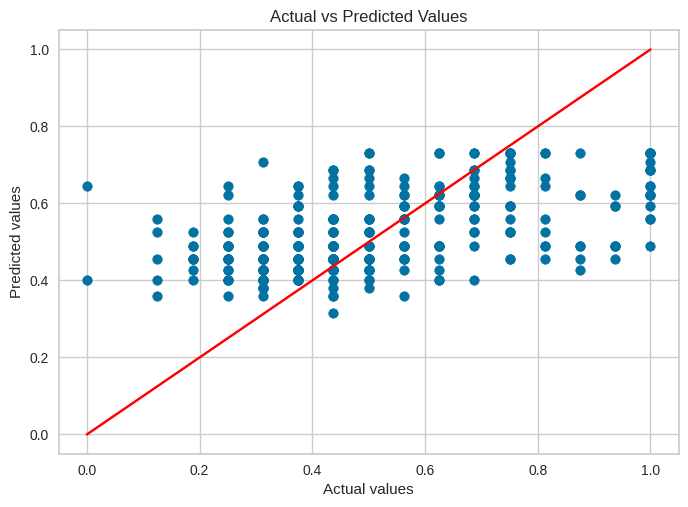

In [331]:
# Plotting the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Perfect prediction line
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Values")
plt.show()

In [332]:
print(best_model)

LinearRegression(n_jobs=-1)


In [333]:
scaler = MinMaxScaler(feature_range=(0, 1))

# For simplicity, we treat 'medv' as time series, though it's not the best choice for LSTM
scaled_data = scaler.fit_transform(df[['LengthofCycle']].values)

# Reshape data to 3D: [samples, time steps, features]
def create_lstm_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_lstm_dataset(scaled_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# 2. Define LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Train the LSTM model
lstm_model.fit(X, y, epochs=10, batch_size=32)

# 4. Make predictions using the LSTM model
predictions_lstm = lstm_model.predict(X)

# Rescale predictions back to the original range
predictions_lstm_rescaled = scaler.inverse_transform(predictions_lstm)

# Save the LSTM model
lstm_model.save('lstm_model.h5')

# Print LSTM predictions (for demo purposes)
print(predictions_lstm_rescaled[:5])  # Show first 5 predictions

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1500
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0367
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0360
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0347
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0370
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0348
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0336
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0311
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0323
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0328
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[[27.332787]
 [27.241459]
 [27.511623]
 [27.587118]
 [27.70964 ]]


In [334]:
rmse = np.sqrt(mean_squared_error(y, predictions_lstm_rescaled))
mse = mean_squared_error(y, predictions_lstm_rescaled)
mae = mean_absolute_error(y, predictions_lstm_rescaled)
r2 = r2_score(y, predictions_lstm_rescaled)

# Print the performance metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

RMSE: 28.259984502958087
MAE: 28.215525254060704
MSE: 798.6267241074312
R²: -17389.467300829583


In [335]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Assuming 'df' is your dataframe and 'EstimatedDayofOvulation' is the target column

# Step 1: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['LengthofCycle']].values)

# Define your features and target
X = scaled_data[:-1]  # All but the last value as features
y = scaled_data[1:]   # All but the first value as target (this is a time series prediction)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the ANN Model
ann_model = Sequential()
ann_model.add(Dense(units=64, activation='relu', input_dim=1))  # Input layer
ann_model.add(Dense(units=32, activation='relu'))               # Hidden layer 1
ann_model.add(Dense(units=16, activation='relu'))               # Hidden layer 2
ann_model.add(Dense(units=1))                                  # Output layer

# Step 4: Compile the Model
ann_model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Model
ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Make Predictions
y_pred = ann_model.predict(X_test)

# Step 7: Rescale predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Step 8: Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print performance metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

# Optionally, save the trained model
ann_model.save('ann_model.h5')


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1230 - val_loss: 0.0360
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376 - val_loss: 0.0346
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - val_loss: 0.0363
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 - val_loss: 0.0348
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 - val_loss: 0.0349
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0370 - val_loss: 0.0349
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0370 - val_loss: 0.0349
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0368 - val_loss: 0.0349
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347 - val_loss: 0.0348
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 - val_loss: 0.0362
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - val_loss: 0.0350
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401 - val_lo

RMSE: 2.98729712923584
MAE: 2.3202829881147906
MSE: 8.92394413834069
R²: 0.27941138160604195
